In [3]:
# Setup Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Global imports
import json
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

# Typing import
from typing import List, Dict, Union

# Specific imports
from copy import deepcopy
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.animation import FuncAnimation, PillowWriter
from rich import print
from termcolor import cprint
from time import time

# Local imports
from read_csv import read_meta_info

sns.set_theme('notebook')
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

def print_bl():
    print("\n")


def print_red(*args):
    for arg in args:
        cprint(arg, "red", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_green(*args):
    for arg in args:
        cprint(arg, "green", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_highlight(*args):
    for arg in args:
        cprint(arg, "magenta", "on_white", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

def print_blue(*args):
    for arg in args:
        cprint(arg, "light_blue", end=' ')  # Using end=' ' to print all arguments on the same line
    print()

In [4]:
class GroupExtractor:
    """
    A class that extracts vehicle groups from a highD dataset recording
    
    Attributes:
        dataset_location: a path to the directory in which the dataset is stored.
        dataset_index: index of the recording that is to be addressed
        data: the raw data of the recording.
        static_info: the static information of the recording.
        video_info: the video information of the recording.
        frame_length: the length of each frame in milliseconds.
        sampling_period: the time spacing between each frame to consider.
        frame_spacing: the number of frames to skip between each frame.
        window_size: the size of the window to consider.
        windows: a list of dataframes with the windows.
        num_lane_changes: a dictionary with the number of lane changes for each vehicle.
        lane_changers: a list of vehicles that change lanes.
        ego_vehicles: a list of ego vehicles - one for each window.
        groups: a list of vehicle groups.

    Methods:        
        filter_data: Filters the dataset with a certain sampling period.
        get_frame_windows: Splits the dataset into windows of a certain size."""  """
        get_ego_vehicles: Selects the ego vehicle for each window.
        get_groups: Groups vehicles in each window based on their proximity to the ego vehicle.
    """
    def __init__(self, dataset_location: str = None, dataset_index: int = None):
        """
        Initializes the PromptExtractor class.

        Args:
            dataset_location (str): The path to the directory in which the dataset is stored.
            dataset_index (int): The index of the recording that is to be addressed.
        """
        ### Error handling
        if dataset_location is None:
            raise ValueError("Please provide a dataset location.")
        if dataset_index is None or dataset_index < 1 or dataset_index > 60:
            raise ValueError("Please provide a dataset index between 1 and 60")
        
        # retrieve raw data
        self.dataset_index  = dataset_index
        self.dataset_location = dataset_location
        self.df_location = dataset_location + str(dataset_index).zfill(2) + "_tracks.csv"
        self.static_info_location = dataset_location + str(dataset_index).zfill(2) + "_tracksMeta.csv"
        self.video_info_location = dataset_location + str(dataset_index).zfill(2) + "_recordingMeta.csv"

        self.data = pd.read_csv(self.df_location)
        self.static_info = pd.read_csv(self.static_info_location)
        self.video_info = read_meta_info(self.video_info_location)

        self.longest_trajectory = self.static_info["traveledDistance"].max()

        #initialize attributes
        self.frame_length = 40 # each frame is 40 ms
        self.sampling_period = 0
        self.frame_spacing = 0.0

        self.raw_data = self.data.copy()
        self.framing_dict = {}

        self.window_size = 0
        self.windows = []
        self.new_windows = []

        self.num_lane_changes = {}
        self.lane_changers = []

        self.ego_vehicles = []
        self.groups = []

        self.bg_image = None

        self.get_background_img(dataset_location + str(dataset_index).zfill(2) + "_highway.png")

    def get_background_img(self, path):
        '''
        Sets the background image for plotting and creating gifs.
            Parameters:
                path (str): path to the png file that contains the background image
            Returns:
                Nothing
        '''
        self.bg_image = plt.imread(path)
        self.bg_image_scaling_factor = np.max((np.max(self.bg_image.shape), self.longest_trajectory)) / np.min((np.max(self.bg_image.shape), self.longest_trajectory))  # Calculates the scaling factor between img size and trajectory length

    def filter_data(self, sampling_period: int = 1000) -> pd.DataFrame:
        """
        Filters the dataset with a certain sampling period.

        Args:
            sampling_period (int): The time spacing between each frame to consider.
        Returns:
            The filtered dataset in the form of a pandas dataframe.
        """
        ### Argument validation
        if sampling_period % self.frame_length != 0:
            raise ValueError("Sampling period must be a multiple of 40ms.")
        
        self.sampling_period = sampling_period
        self.frame_spacing = int(self.sampling_period / self.frame_length) #Frames are 40 ms apart

        ### Printing parameters
        print("Filtering data with the following parameters:")
        print_green(f"Sampling period: {self.sampling_period} ms")
        print_green(f"Frame spacing: {self.frame_spacing} frames")

        self.data = self.data[self.data.frame % self.frame_spacing == 0]
        self.raw_frames = deepcopy(self.data.frame) # copy the old frame numbering for animation purposes
        self.data.frame = self.data.frame / self.frame_spacing
        self.framing_dict = dict(zip(self.data.frame, self.raw_frames)) # create a dictionary to convert old frame numbering to new frame numbering
        self.data = self.data.astype({'frame': 'int16'})

        return self.data

    def get_frame_windows(self, window_size: int = 5) -> List[pd.DataFrame]:
        """
        Splits the dataset into windows of a certain size.

        Args:
            window_size (int): The size of the window to consider.

        Returns:
            A list of dataframes with the windows.
        """
        ### Runtime error handling
        if self.sampling_period == 0:
            raise RuntimeError("Data has not been filtered - Call filter_data() first with the desired sampling period.")
        
        ### Argument validation            
        if window_size < 1:
            raise ValueError("Window size must be greater than 0.")
        if window_size > len(self.data):
            raise ValueError("Window size must be less than the length of the dataset.")

        self.window_size = window_size

        ### Printing parameters
        print("Creating windows with the following parameters:")
        print_green(f"Window size: {self.window_size} frames")

        self.windows.clear() # clear windows list
        for i in range(1, len(self.data), window_size):
            window = self.data[self.data['frame'].isin(range(i, i+window_size))]
            self.windows.append(window) #no overlap
        return self.windows
    
    def get_ego_vehicles(self) -> List[int]:
        """
        Selects the ego vehicle for each window. The ego vehicle is chosen as a vehicle that is present in all frames of the window and changes lanes at least once.

        Returns:
            A list of ego vehicles - one for each window.
        """
        ### Runtime error handling
        if not self.windows:
            raise RuntimeError("No windows have been created. Please run get_frame_windows() first.")

        lookback = self.window_size
        ego_candidates = []
        all_present = []
        defective_windows = 0
        
        ### Printing parameters
        print("Selecting ego vehicles with the following parameters:")
        print_green(f"Lookback: {lookback} frames")

        #get vehicles that change lanes at least once
        self.num_lane_changes = self.static_info[['id', 'numLaneChanges']].set_index('id').to_dict()['numLaneChanges'] # convert df with id and numLaneChanges to dict [id: numLaneChanges]
        #convert into list of ids that change lanes 
        self.lane_changers = [k for k, v in self.num_lane_changes.items() if v > 0]

        for i, window in enumerate(self.windows):
            #choose ego vehicle 
            ego_candidates.clear()
            all_present.clear()
            id_counts = window.id.value_counts().to_dict()
            all_present = [vehicle_id for vehicle_id in id_counts.keys() if id_counts[vehicle_id] == lookback] #ensure ego vehicle is present in all frames
            if not all_present:
                defective_windows += 1
                continue
            #get ego_candidates that change lane at least once and choose one of them
            ego_candidates = list(set(all_present) & set(self.lane_changers))
            if not ego_candidates: #if there are no lane changers, choose random ego vehicle
                ego_candidate = random.choice(all_present)
                self.ego_vehicles.append(ego_candidate)
                self.new_windows.append(window)
            else: 
                for ego_candidate in ego_candidates:
                    self.new_windows.append(window)
                    self.ego_vehicles.append(ego_candidate) 

        self.windows = self.new_windows

        return self.ego_vehicles

    def get_groups(self, bubble_radius: float|int = 50) -> List[pd.DataFrame]:
        """
        Groups vehicles in each window based on their proximity to the ego vehicle. Uses the bubble radius to determine whether a vehicle is in the bubble of the ego vehicle.
        Args:
            bubble_radius (float): The radius of the bubble around the ego vehicle.

        Returns:
            A list of vehicle groups.
        """
        def in_bubble(ego_vehicle, x, radius = bubble_radius):
            '''
            Calculates whether a vehicle is in the bubble of the ego vehicle. Checks distance between ego vehicle and target, as well as driving direction.
            Notation: 
                (x, y) - coordinates of the top left corner of the bounding box of the vehicle.
                (w, h) - width and height of the bounding box.

                Parameters:
                    ego_vehicle: dataframe row with information about the ego vehicle
                    x: dataframe row with information about the vehicle to consider
                Returns:
                    bool: True if the vehicle is in the bubble, False otherwise
                    
            '''
            x1, y1, w1, h1 = ego_vehicle.x, ego_vehicle.y, ego_vehicle.width, ego_vehicle.height
            x2, y2, w2, h2 = x.x, x.y, x.width, x.height
            c1 = np.array([x1 + w1/2, y1 + h1/2])
            c2 = np.array([x2 + w2/2, y2 + h2/2])
            dist = np.linalg.norm(c1-c2)
            dist_check = dist < radius
            sign_check = np.sign(x.xVelocity) == np.sign(ego_vehicle.xVelocity)
            ret = dist_check & sign_check

            return ret
        
        ### Runtime error handling
        if not self.ego_vehicles:
            raise RuntimeError("No ego vehicles have been selected. Please run get_ego_vehicles() first.")
        
        ### Argument validation
        if bubble_radius <= 0:
            raise ValueError("Bubble radius must be greater than 0.")
        
        bubble_radius = float(bubble_radius) # convert to float if int
        
        self.bubble_radius = bubble_radius

        ### Printing parameters
        print("Grouping vehicles with the following parameters:")
        print_green(f"Bubble radius: {bubble_radius} meters")

        current_group = pd.DataFrame(columns=self.data.columns)
        for i, window in enumerate(self.windows):
            current_group = current_group.iloc[0:0] # clear current_group
            #iterate through each frame in the window
            for frame_num, df_group in window.groupby("frame"): #separate the window by frame and iterate through each frame
                ego_vehicle = df_group[df_group.id == self.ego_vehicles[i]]
                #apply mask to window to get vehicles in bubble and concatenate to current_group
                current_group = pd.concat([current_group, df_group[df_group.apply(lambda x: in_bubble(ego_vehicle.iloc[0], x), axis=1)]])
            self.groups.append(current_group) # append current_group to groups

        return self.groups
    
    def save_groups(self, save_path: str = None):
        """
        Saves the vehicle groups to a single json file.

        Args:
            save_path (str): The path to save the json file.
        """
        if save_path is None:
            raise ValueError("Please provide a save path for the CSV file.")
        
        if not self.groups:
            raise RuntimeError("No groups to save. Please run the group creation pipeline first.")

        json_dict = {}
        # Save each group to a separate json file
        for i, group in enumerate(self.groups):
            json_dict[f'group_{i}'] = group.to_json(orient='records')

        with open(save_path + f"/groups_{self.dataset_index}.json", 'w') as f:
            json.dump(json_dict, f)

        #save ego vehicles list to a separate file
        with open(save_path + f"/ego_vehicles_{self.dataset_index}.json", 'w') as f:
            json.dump(self.ego_vehicles, f)
        
        print(f"Groups saved to {save_path}" + f"/groups_{self.dataset_index}.json")
        print(f"Ego vehicles saved to {save_path}" + f"/ego_vehicles_{self.dataset_index}.json")
    
    def plot_groups(self, group_num: int = 0, save: bool = False, save_path: str = None):
        """
        Plots the vehicles in a specified group, showing their positions and ids.

        Args:
            group_num (int): The index of the group to plot. Default is 0.
            save (bool): Whether to save the plot as an image. Default is False.
            save_path (str): The path to save the plot image. Required if save is True.
        """
        # Check if groups attribute exists
        if not hasattr(self, 'groups') or not self.groups:
            raise RuntimeError("No groups to plot. Please run the group creation pipeline first.")

        # Ensure the group number is within range
        if group_num < 0 or group_num >= len(self.groups):
            raise ValueError(f"Group number {group_num} is out of range.")

        # Create a new figure for the plot with a reasonable size
        fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
        ax.set_aspect('equal')

        # Get the group to plot
        group = self.groups[group_num]

        # Get the maximum frame number for this group
        max_frame = group['frame'].max()

        # Determine plot limits
        x_min, x_max = group['x'].min(), group['x'].max()
        y_min, y_max = group['y'].min(), group['y'].max()
        ax.set_xlim(x_min - 10, x_max + 10)  # Adding some padding
        ax.set_ylim(y_min - 10, y_max + 10)

        # Set labels and title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Group {group_num} Vehicle Positions')

        #Axis orientation - vehicles moving left or right
        if group['xVelocity'].mean() > 0:
            ax.invert_yaxis()
            lane_markings = self.video_info["lowerLaneMarkings"]
        else:
            ax.invert_xaxis()
            lane_markings = self.video_info["upperLaneMarkings"]

        # Draw lane markings
        for lane_marking in lane_markings:
            ax.plot([x_min, x_max], [lane_marking, lane_marking], color='black', linestyle='--', linewidth=1)


        # Iterate over each row in the group
        for _, row in group.iterrows():
            # Determine the color based on the frame number
            color_intensity = row['frame'] / max_frame
            if row['id'] == self.ego_vehicles[group_num]:
                color = (0, color_intensity, 0, 0.5)  # Shades of green for the ego vehicle
            else:
                color = (0, 0, color_intensity, 0.5)  # Shades of blue for other vehicles

            # Create a rectangle centered at the vehicle's position
            rect = Rectangle((row['x'] - row['width'] / 2, row['y'] - row['height'] / 2), 
                            row['width'], row['height'], 
                            linewidth=1, edgecolor='black', facecolor=color)

            # Add the rectangle to the plot
            ax.add_patch(rect)

            # Print the vehicle's ID and frame number near the vehicle
            ax.text(row['x'], row['y'] + row['height'] + 1, str(row['id']), fontsize=10, ha='center', va='center', color='red')
            #ax.text(row['x'], row['y'] - row['height'] - 0.2, str(row['frame'] - max_frame + 4), fontsize=7, ha='center', va='center', color='red')

        # Save the plot if requested
        if save:
            if save_path is None:
                print("No save path provided. Plot will not be saved.")
            else:
                plt.savefig(save_path)
                print(f"Plot saved to {save_path}")

        # Show the plot
        plt.show()

    def animate_groups(self, group_num: int = 0, interval: int = 100, dense: bool = False, save: bool = False, save_path: str = None):
        """
        Creates an animation of the vehicles in a specified group, showing their positions and ids over time.

        Args:
            group_num (int): The index of the group to animate. Default is 0.
            save (bool): Whether to save the animation as a video. Default is False.
            save_path (str): The path to save the animation video. Required if save is True.
            interval (int): The time interval between frames in milliseconds. Default is 100.
            dense (bool): Whether to show all frames or frames separated with the sampling period of the extractor. Default is False.
        """
        # Check if groups attribute exists
        if not hasattr(self, 'groups') or not self.groups:
            raise RuntimeError("No groups to plot. Please run the group creation pipeline first.")

        # Ensure the group number is within range
        if group_num < 0 or group_num >= len(self.groups):
            raise ValueError(f"Group number {group_num} is out of range.")

        # Get the group to animate
        if not dense:
            group = self.groups[group_num]
        else: #get dense data for the group by fitering the original dataframe
            min_frame = self.groups[group_num]['frame'].min() #get the start frame of animation in new framing sequence
            start_frame = self.framing_dict[min_frame] #convert it to old framing sequence
            end_frame = start_frame + self.frame_spacing*self.window_size #get the end frame of animation in old framing sequence
            group = self.raw_data[(self.raw_data['frame'] >= start_frame) & (self.raw_data['frame'] <= end_frame)] #get the data for the frames between start and end frame
            group = group[group['id'].isin(self.groups[group_num]['id'])] #filter the data to include only the vehicles in the group
            group = group.astype({'frame': 'int16', 'id': 'int32'})
            interval = self.frame_length #set interval to 40ms for dense data
        # Get the maximum frame number for this group
        max_frame = group['frame'].max()
        min_frame = group['frame'].min()
        # Determine plot limits
        x_min, x_max = group['x'].min(), group['x'].max()
        y_min, y_max = group['y'].min(), group['y'].max()

        display(group)

        # Create a new figure for the animation with a reasonable size
        fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
        ax.set_aspect('equal')
        ax.set_xlim(x_min - 10, x_max + 10)  # Adding some padding
        ax.set_ylim(y_min - 10, y_max + 10)

        # Set labels and title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Group {group_num} Vehicle Positions')

        #Axis orientation - vehicles moving left or right
        if group['xVelocity'].mean() > 0:
            ax.invert_yaxis()
            lane_markings = self.video_info["lowerLaneMarkings"]  #correct lane marking position for better visualization
        else:
            ax.invert_xaxis()
            lane_markings = self.video_info["upperLaneMarkings"]  #correct lane marking position for better visualization

        # Draw lane markings
        for lane_marking in lane_markings:
            ax.plot([x_min, x_max], [lane_marking, lane_marking], color='black', linestyle='--', linewidth=1)

        # Initialize a list to hold the rectangle patches and text annotations
        patches = []

        ## Print parameters
        print("Animating vehicles with the following parameters:")
        print_green(f"Group number: {group_num}")
        print_green(f"Interval: {interval} ms")
        print_green(f"Dense: {dense}")
        print_green(f"Min and max frame: {min_frame}, {max_frame}")
        print_green(f"Number of frames: {max_frame - min_frame + 1}")

        def init():
            """Initialize the plot with empty patches and text annotations."""
            for patch in patches:
                patch.remove()
            patches.clear()

            return patches

        def update(frame):
            """Update the plot for each frame of the animation."""
            init()  # Clear previous patches and text annotations
            frame_data = group[group['frame'] == frame+min_frame] #get the data for the current frame
            for _, row in frame_data.iterrows():
                # Determine the color based on the frame number
                color_intensity = row['frame'] / max_frame
                if row['id'] == self.ego_vehicles[group_num]:
                    color = (0, color_intensity, 0, 0.5)  # Shades of green for the ego vehicle
                else:
                    color = (0, 0, color_intensity, 0.5)  # Shades of blue for other vehicles

                # Create a rectangle centered at the vehicle's position
                rect = Rectangle((row['x'] - row['width'] / 2, row['y'] - row['height'] / 2),
                                row['width'], row['height'],
                                linewidth=1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)
                patches.append(rect)

                # Add text annotations for the vehicle's ID and frame number
                id_text = ax.text(row['x'], row['y'] + row['height'] / 2 + 1, 'id: ' + str(int(row['id'])), fontsize=10, ha='center', va='center', color='red')
                #frame_text = ax.text(row['x'], row['y'] - row['height'] / 2 - 0.5, 'frame: ' + str(int(row['frame'])), fontsize=7, ha='left', va='center', color='red')
                #patches.extend([id_text, frame_text])
                patches.append(id_text)

            return patches

        # Create the animation
        anim = FuncAnimation(fig, update, frames=range(max_frame - min_frame + 1), init_func=init, blit=True, repeat=False, interval = interval)

        # Save the animation if requested
        if save:
            if save_path is None:
                print("No save path provided. Animation will not be saved.")
            else:
                anim.save(save_path, writer=PillowWriter(fps=1000/interval))
                print(f"Animation saved to {save_path}")

        # Display the animation
        plt.show()


In [7]:
dataset_location = "/home/lmmartinez/Tesis/datasets/highD/data/"

    
dataset_index = 1
start = time()
scene_data = GroupExtractor(dataset_location=dataset_location, dataset_index=dataset_index)
end = time()
print("Time elapsed is:", end - start)
start = time()
scene_data.filter_data(sampling_period=1000)
end = time()
print("Time elapsed is:", end - start)
start = time()
scene_data.get_frame_windows(window_size=4)
end = time()
print("Time elapsed is:", end - start)
start = time()
scene_data.get_ego_vehicles()
end = time()
print("Time elapsed is:", end - start)
start = time()
scene_data.get_groups(bubble_radius=50)
end = time()
print("Time elapsed is:", end - start)

Time elapsed is: 0.16066694259643555

Filtering data with the following parameters:

Sampling period: 1000 ms 

Frame spacing: 25 frames 

Time elapsed is: 0.0063626766204833984

Creating windows with the following parameters:

Window size: 4 frames 

Time elapsed is: 1.0886163711547852

Selecting ego vehicles with the following parameters:

Lookback: 4 frames 

Time elapsed is: 0.25089311599731445

Grouping vehicles with the following parameters:

Bubble radius: 50.0 meters 

Time elapsed is: 2.566715955734253

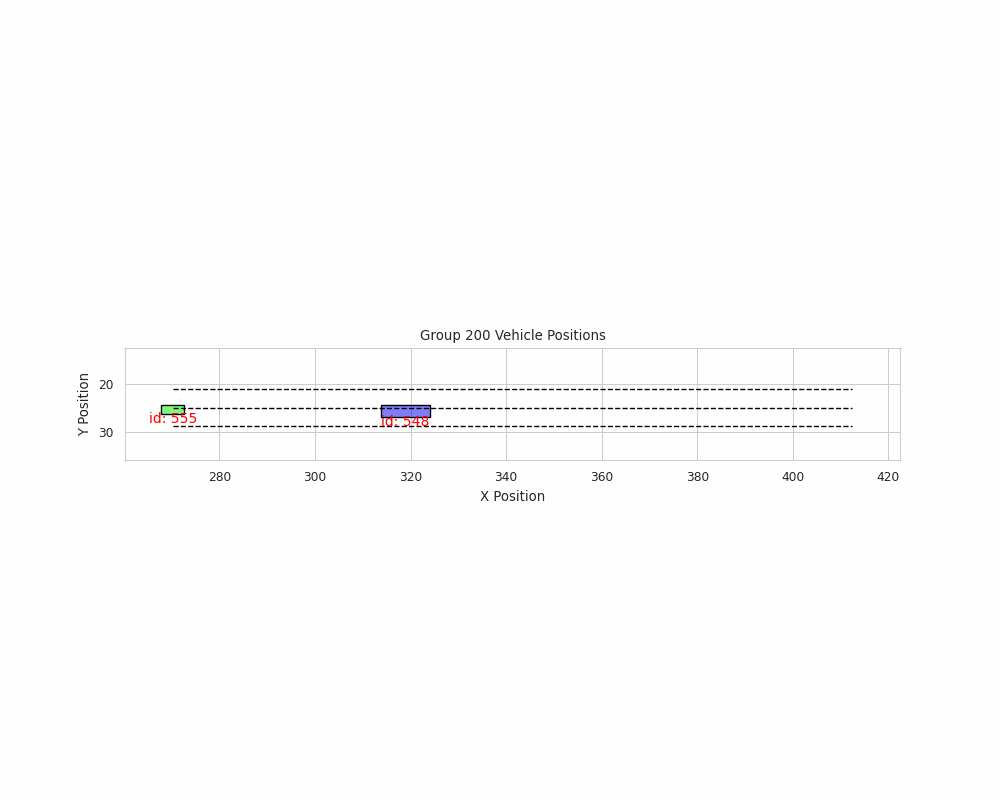

In [140]:
from IPython.display import Image, display
with open('./test.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [9]:
scene_data.save_groups(save_path="./test_save")

Groups saved to ./test_save

In [10]:
with open("./test_save/groups_1", 'r') as f:
    data = json.load(f)

groups = [pd.read_json(data[f]) for f in data.keys()]
groups[0]


,frame,id,x,y,width,height,xVelocity,yVelocity,xAcceleration,yAcceleration,...,precedingXVelocity,precedingId,followingId,leftPrecedingId,leftAlongsideId,leftFollowingId,rightPrecedingId,rightAlongsideId,rightFollowingId,laneId
0,1,5,268.74,13.78,4.24,1.82,-42.93,-0.04,-0.43,0.01,...,-42.80,4,0,0,0,0,8,0,9,3
1,1,9,283.04,9.45,4.85,2.02,-36.16,0.15,-0.18,0.27,...,-31.51,8,0,5,0,0,0,0,0,2
2,2,5,225.57,13.75,4.24,1.82,-43.27,-0.04,-0.23,-0.01,...,-42.76,4,0,0,0,0,8,0,9,3
3,2,9,246.80,9.78,4.85,2.02,-36.33,0.51,-0.15,0.29,...,-31.50,8,0,5,0,0,0,0,0,2
4,3,5,182.19,13.68,4.24,1.82,-43.40,-0.06,-0.04,0.03,...,-42.77,4,0,0,0,0,8,0,9,3
5,3,9,210.38,10.44,4.85,2.02,-36.44,0.78,-0.08,0.16,...,-31.40,8,0,5,0,0,0,0,0,2
6,4,5,138.77,13.66,4.24,1.82,-43.39,0.03,0.00,0.05,...,-42.82,4,17,0,0,0,8,0,9,3
7,4,9,173.91,11.28,4.85,2.02,-36.51,0.84,-0.07,-0.02,...,-31.28,8,16,5,0,17,0,0,0,2


In [ ]:
for i in range(1, 61):
    print(f"Processing dataset {i}")
    scene_data = GroupExtractor(dataset_location=dataset_location, dataset_index=i)
    scene_data.filter_data(sampling_period=1000)
    scene_data.get_frame_windows(window_size=4)
    scene_data.get_ego_vehicles()
    scene_data.get_groups(bubble_radius=50)